In [42]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [21]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  0.643005  0.643005  0 -1.329844 -1.329844
1 -0.698093 -0.698093  0 -0.227882 -0.227882
2 -0.141419 -0.141419  0  0.509963  0.509963
3  0.749721  0.749721  0  1.277306  1.277306
4 -0.455828 -0.455828  1 -1.354143 -1.809970
5 -0.120606 -0.120606  0  0.416748  0.416748
6 -1.101371 -1.101371  1 -0.175742 -1.277113
7  0.949910  0.949910  0  0.049566  0.049566
8  1.548950  1.548950  1  1.622123  3.171074
9  0.000047  0.000047  0 -0.572334 -0.572334


#### Categorical Model

In [22]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1       tau  Z   epsilon         Y
0 -2.356121  0.000000  1 -0.833770 -0.833770
1 -0.055824  0.000000  0 -0.576049 -0.576049
2  1.771291  1.771291  1 -0.706690  1.064600
3 -0.183644  0.000000  1 -0.163965 -0.163965
4  0.295631  0.295631  1 -0.084823  0.210809
5  0.432699  0.432699  1  1.980787  2.413485
6 -0.817441  0.000000  0  1.476533  1.476533
7 -0.196703  0.000000  0 -0.837659 -0.837659
8  2.391112  2.391112  0 -0.908145 -0.908145
9 -1.236624  0.000000  0 -2.174994 -2.174994


#### Assigning variables for econml metalearner functions

In [23]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

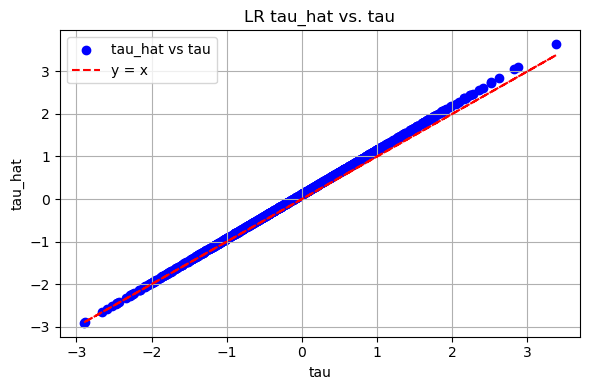

In [32]:
data['X1*Z'] = data['X1'] * data['Z'] #Setting interaction term
lr_xfit = data[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [33]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.014471702507671828
Bias: -0.11297444617545714
R2 0.9860681523879227


## X-Learner

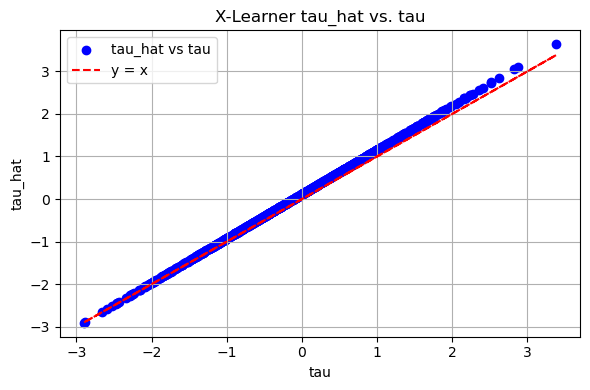

In [26]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [27]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.014471702507671904
Bias: -0.11297444617545732
R2 0.9860681523879226


## DR-Learner

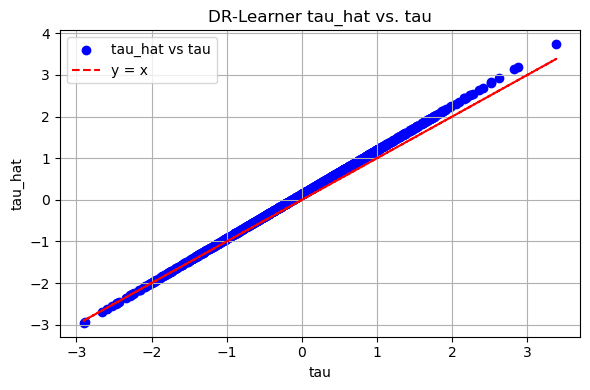

In [28]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [29]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.021716039159388734
Bias: -0.13234047918232056
R2 0.9790940597247545


## Causal Forest

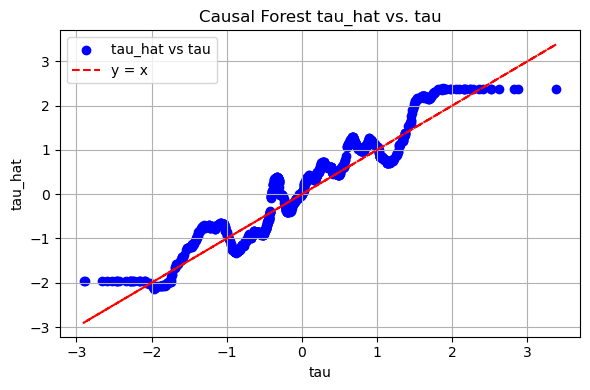

In [30]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [31]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.11626527289787954
Bias: -0.1235539391564813
R2 0.8880719069694011
